In [0]:
%run ./config

demo_yt_mlops@outlook.com


Out[25]: <Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/4119769509188008', creation_time=1675589006729, experiment_id='4119769509188008', last_update_time=1675589006729, lifecycle_stage='active', name='/Users/demo_yt_mlops@outlook.com/DT-2023/airbnb_hawaii', tags={'mlflow.experiment.sourceName': '/Users/demo_yt_mlops@outlook.com/DT-2023/airbnb_hawaii',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'demo_yt_mlops@outlook.com',
 'mlflow.ownerId': '5792412687435845'}>

Out[27]: '4119769509188008'

Out[31]: False

+-----+------------+--------+----+--------------+-----------------+---------------------+--------------------+-----------------+----------------------+----------------+---------------+
|price|accommodates|bedrooms|beds|minimum_nights|number_of_reviews|number_of_reviews_ltm|review_scores_rating|host_is_superhost|neighbourhood_cleansed|   property_type|      room_type|
+-----+------------+--------+----+--------------+-----------------+---------------------+--------------------+-----------------+----------------------+----------------+---------------+
|150.0|           2|       1|   1|             3|               11|                    2|                  88|                t|          South Kohala|Entire apartment|Entire home/apt|
| 85.0|           2|       1|   1|             5|              168|                    2|                  93|                f|            South Kona|Entire apartment|Entire home/apt|
+-----+------------+--------+----+--------------+-----------------+--------

In [0]:
# Incoming run_0 Data
month_0_df = spark.read.format("delta").load(month_0_delta_path)

# Create inital version of the Gold Delta table we will use for training - this will be updated with subsequent "months" of data
month_0_df.withColumn("month", F.lit("month_0")).write.format("delta").partitionBy("month").save(gold_delta_path)

In [0]:
month = 0
run_name = f"month_{month}"
model_params = {"n_estimators": 500,
                "max_depth": 5,
                "max_features": "log2"}
misc_params = {"month": month,
               "target_col": target_col,
               "cat_cols": cat_cols,
               "num_cols": num_cols}
month_0_run = train_sklearn_rf_model(run_name, 
                                     gold_delta_path, 
                                     model_params, 
                                     misc_params)

<command-4119769509187986>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  median_vals = pdf.median()


In [0]:
# Register model to MLflow Model Registry
month_0_run_id = month_0_run.info.run_id
month_0_model_version = mlflow.register_model(model_uri=f"runs:/{month_0_run_id}/model", name=registry_model_name)

# Transition model to Production
month_0_model_version = transition_model(month_0_model_version, stage="Production")
print(month_0_model_version)

Registered model 'airbnb_hawaii' already exists. Creating a new version of this model...
2023/02/05 09:53:02 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: airbnb_hawaii, version 3
Created version '3' of model 'airbnb_hawaii'.
<ModelVersion: creation_timestamp=1675590782127, current_stage='Production', description='', last_updated_timestamp=1675590788515, name='airbnb_hawaii', run_id='18d7d7f86a02426c9c3dc58e17419cf2', run_link='', source='dbfs:/databricks/mlflow-tracking/4119769509188008/18d7d7f86a02426c9c3dc58e17419cf2/artifacts/model', status='READY', status_message='', tags={}, user_id='5792412687435845', version='3'>


In [0]:
month_1_err_pdf = spark.read.format("delta").load(month_1_error_delta_path).toPandas()
 
# Compute summary statistics on new incoming data
summary_stats_month_1_err_pdf = create_summary_stats_pdf(month_1_err_pdf)

<command-4119769509187986>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  median_vals = pdf.median()


In [0]:
# Get the original MLflow run associated with the model registered under Production
current_prod_run_1 = get_run_from_registered_model(registry_model_name, stage="Production")
 
# Load in original versions of Delta table used at training time for current Production model
current_prod_pdf_1 = load_delta_table_from_run(current_prod_run_1).toPandas()
 
# Load summary statistics pandas DataFrame for data which the model currently in Production was trained and evaluated against
current_prod_stats_pdf_1 = load_summary_stats_pdf_from_run(current_prod_run_1, project_local_tmp_dir)

Loading Delta table from path: /Users/demo_yt_mlops@outlook.com/ram_drift/data/airbnb_hawaii_delta; version: 0
<command-4119769509187990>:5: FutureWarning: ``mlflow.tracking.client.MlflowClient.download_artifacts`` is deprecated since 2.0. This method will be removed in a future release. Use ``mlflow.artifacts.download_artifacts`` instead.
  local_path = client.download_artifacts(run.info.run_id, "summary_stats.csv", local_tmp_dir)
Summary stats artifact downloaded in: /dbfs/Users/demo_yt_mlops@outlook.com/ram_drift/tmp/summary_stats.csv


In [0]:
print("Null Check.....")
check_null_proportion(month_1_err_pdf, null_proportion_threshold=.5)

Null Check.....
Alert: There are feature(s) that exceed(s) the expected null threshold. Please ensure that the data is ingested correctly
{'neighbourhood_cleansed': 0.6337819650067295}


In [0]:
statistic_list = ["mean", "median", "std", "min", "max"]
 
# Check if the new summary stats deviate from previous summary stats by a certain threshold
unique_feature_diff_array_month_1 = check_diff_in_summary_stats(summary_stats_month_1_err_pdf, 
                                                                current_prod_stats_pdf_1, 
                                                                num_cols + [target_col], # Include the target col in this analysis
                                                                stats_threshold_limit, 
                                                                statistic_list)
unique_feature_diff_array_month_1


CHECKING accommodates.........

CHECKING bedrooms.........

CHECKING beds.........

CHECKING minimum_nights.........

CHECKING number_of_reviews.........
	The max number_of_reviews in the new data is at least 5.0% lower than the max in the production data. Decreased from 739.0 to 569.0.

CHECKING number_of_reviews_ltm.........
	The max number_of_reviews_ltm in the new data is at least 5.0% lower than the max in the production data. Decreased from 105.0 to 89.0.

CHECKING review_scores_rating.........
	The mean review_scores_rating in the new data is at least 5.0% lower than the mean in the production data. Decreased from 94.92 to 3.48.
	The median review_scores_rating in the new data is at least 5.0% lower than the median in the production data. Decreased from 97.0 to 4.75.
	The std review_scores_rating in the new data is at least 5.0% lower than the std in the production data. Decreased from 7.89 to 2.12.
	The min review_scores_rating in the new data is at least 5.0% lower than the m

Let's look at the box plots of the features that exceed the stats_threshold_limit of 0.05


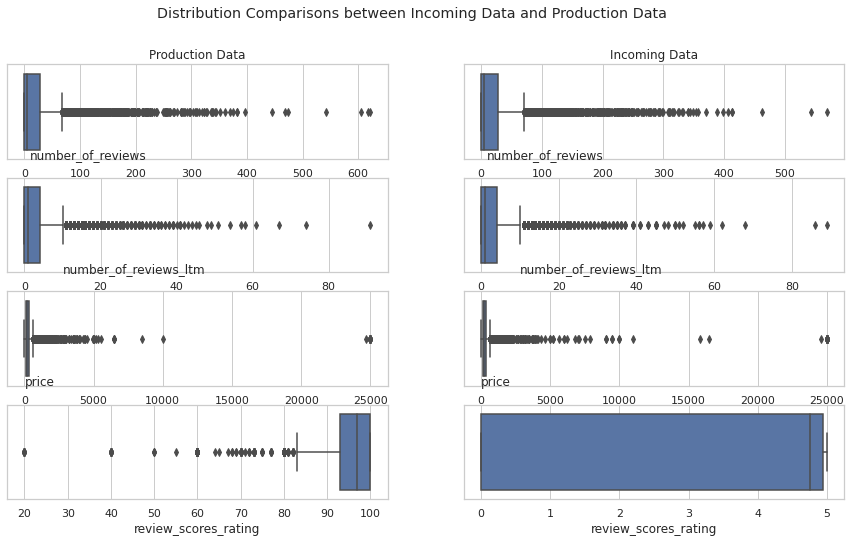

In [0]:
print(f"Let's look at the box plots of the features that exceed the stats_threshold_limit of {stats_threshold_limit}")
plot_boxplots(unique_feature_diff_array_month_1, current_prod_pdf_1, month_1_err_pdf)

In [0]:
print("\nCheck variance using Levene test.....")
check_diff_in_variances(current_prod_pdf_1, month_1_err_pdf, num_cols, p_threshold)


Check variance using Levene test.....
No features have significantly different variances compared to production data at p-value 0.05


In [0]:
print("\nKs Test.....")
check_dist_ks_bonferroni_test(current_prod_pdf_1, month_1_err_pdf, num_cols, p_threshold)


Ks Test.....
The Bonferroni-corrected alpha level is 0.0071. Any features with KS statistic below this alpha level have shifted significantly.
The feature(s) below have significantly different distributions compared to production data at Bonferroni-corrected alpha level of 0.0071, according to the KS test
	 {'review_scores_rating': 0.0}


In [0]:
check_categorical_diffs(current_prod_pdf_1, month_1_err_pdf, cat_cols, p_threshold)

The mode for neighbourhood_cleansed has changed from Primary Urban Center to North Shore Kauai.


In [0]:
# Incoming Month 1 Data where upstream errors have been fixed
month_1_df = spark.read.format("delta").load(month_1_fixed_delta_path)
 
# Append new month of data to Gold Delta table to use for training
month_1_df.withColumn("month", F.lit("month_1")).write.format("delta").partitionBy("month").mode("append").save(gold_delta_path)

In [0]:
# Set the month number - used for naming the MLflow run and logged as a parameter
month = 1
 
# Specify name of MLflow run
run_name = f"month_{month}"
 
# Define the parameters to pass in the RandomForestRegressor model
model_params = {"n_estimators": 500,
                "max_depth": 5,
                "max_features": "log2"}
 
# Define a dictionary of parameters that we would like to use during preprocessing
misc_params = {"month": month,
               "target_col": target_col,
               "cat_cols": cat_cols,
               "num_cols": num_cols}
 
# Trigger model training and logging to MLflow
month_1_run = train_sklearn_rf_model(run_name, 
                                     gold_delta_path,   
                                     model_params, 
                                     misc_params)

<command-4119769509187986>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  median_vals = pdf.median()


In [0]:
# Register model to MLflow Model Registry
month_1_run_id = month_1_run.info.run_id
month_1_model_version = mlflow.register_model(model_uri=f"runs:/{month_1_run_id}/model", name=registry_model_name)

Registered model 'airbnb_hawaii' already exists. Creating a new version of this model...
2023/02/05 10:08:02 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: airbnb_hawaii, version 4
Created version '4' of model 'airbnb_hawaii'.


In [0]:
# Transition model to Staging
month_1_model_version = transition_model(month_1_model_version, stage="Staging")
print(month_1_model_version)

<ModelVersion: creation_timestamp=1675591682085, current_stage='Staging', description='', last_updated_timestamp=1675591713931, name='airbnb_hawaii', run_id='d606da99675b4a49bead0121550b8521', run_link='', source='dbfs:/databricks/mlflow-tracking/4119769509188008/d606da99675b4a49bead0121550b8521/artifacts/model', status='READY', status_message='', tags={}, user_id='5792412687435845', version='4'>


In [0]:
# Get the original MLflow run associated with the model registered under Staging
current_staging_run_1 = get_run_from_registered_model(registry_model_name, stage="Staging")
 
metric_to_check = "test_r2"
compare_model_perfs(current_staging_run_1, current_prod_run_1, min_model_r2_threshold, metric_to_check)

Staging run's test_r2: 0.103
Current production run's test_r2: 0.07
The current staging run exceeds the model improvement threshold of at least +0.1. You may proceed with transitioning the staging model to production now.


In [0]:
month_1_model_version = transition_model(month_1_model_version, stage="Production")
print(month_1_model_version)

<ModelVersion: creation_timestamp=1675591682085, current_stage='Production', description='', last_updated_timestamp=1675591842602, name='airbnb_hawaii', run_id='d606da99675b4a49bead0121550b8521', run_link='', source='dbfs:/databricks/mlflow-tracking/4119769509188008/d606da99675b4a49bead0121550b8521/artifacts/model', status='READY', status_message='', tags={}, user_id='5792412687435845', version='4'>


In [0]:
# Incoming Month 2 Data - we have synthesised some distribution changes in our label which we would necessarily want to catch
month_2_df = spark.read.format("delta").load(month_2_delta_path)

In [0]:
# Compute summary statistics on new incoming data
month_2_pdf = month_2_df.toPandas()
summary_stats_month_2_pdf = create_summary_stats_pdf(month_2_pdf)
# Get the original MLflow run associated with the model registered under Production
current_prod_run_2 = get_run_from_registered_model(registry_model_name, stage="Production")

<command-4119769509187986>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  median_vals = pdf.median()


In [0]:
summary_stats_month_2_pdf

,price,accommodates,bedrooms,beds,minimum_nights,number_of_reviews,number_of_reviews_ltm,review_scores_rating,host_is_superhost,neighbourhood_cleansed,property_type,room_type
count,7207.000000,7207.000000,6188.000000,7192.000000,7207.000000,7207.000000,7207.000000,5292.000000,7207,7207,7207,7207
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,30,66,4
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,Primary Urban Center,Entire condominium,Entire home/apt
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4504,1440,3724,6485
mean,774.340318,4.658665,1.799612,2.444244,7.291106,25.406410,3.223255,94.974301,NaN,NaN,NaN,NaN
std,2870.567430,2.314033,1.038574,1.631189,19.762907,49.988445,6.259822,8.008648,NaN,NaN,NaN,NaN
min,22.383787,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,20.000000,NaN,NaN,NaN,NaN
25%,242.411196,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,93.000000,NaN,NaN,NaN,NaN
50%,402.157393,4.000000,2.000000,2.000000,3.000000,5.000000,1.000000,97.000000,NaN,NaN,NaN,NaN
75%,692.600661,6.000000,2.000000,3.000000,5.000000,28.000000,4.000000,100.000000,NaN,NaN,NaN,NaN


In [0]:
current_prod_pdf_2 = load_delta_table_from_run(current_prod_run_2).toPandas()

current_prod_stats_pdf_2 = load_summary_stats_pdf_from_run(current_prod_run_2, project_local_tmp_dir)

Loading Delta table from path: /Users/demo_yt_mlops@outlook.com/ram_drift/data/airbnb_hawaii_delta; version: 1
<command-4119769509187990>:5: FutureWarning: ``mlflow.tracking.client.MlflowClient.download_artifacts`` is deprecated since 2.0. This method will be removed in a future release. Use ``mlflow.artifacts.download_artifacts`` instead.
  local_path = client.download_artifacts(run.info.run_id, "summary_stats.csv", local_tmp_dir)
Summary stats artifact downloaded in: /dbfs/Users/demo_yt_mlops@outlook.com/ram_drift/tmp/summary_stats.csv


In [0]:
print("\nNull.....")
check_null_proportion(month_2_pdf, null_proportion_threshold=.5)


Null.....


In [0]:
unique_feature_diff_array_month_2 = check_diff_in_summary_stats(summary_stats_month_2_pdf, 
                                                                current_prod_stats_pdf_2, 
                                                                num_cols + [target_col], 
                                                                stats_threshold_limit, 
                                                                statistic_list)
 
unique_feature_diff_array_month_2


CHECKING accommodates.........
	The min accommodates in the new data is at least 5.0% higher than the min in the production data. Increased from 0.0 to 1.0.

CHECKING bedrooms.........
	The max bedrooms in the new data is at least 5.0% lower than the max in the production data. Decreased from 17.0 to 14.0.

CHECKING beds.........

CHECKING minimum_nights.........
	The max minimum_nights in the new data is at least 5.0% lower than the max in the production data. Decreased from 365.0 to 200.0.

CHECKING number_of_reviews.........

CHECKING number_of_reviews_ltm.........
	The std number_of_reviews_ltm in the new data is at least 5.0% higher than the std in the production data. Increased from 5.94 to 6.26.

CHECKING review_scores_rating.........

CHECKING price.........
	The mean price in the new data is at least 5.0% higher than the mean in the production data. Increased from 389.14 to 774.34.
	The median price in the new data is at least 5.0% higher than the median in the production dat

Let's look at the box plots of the features that exceed the stats_threshold_limit of 0.05


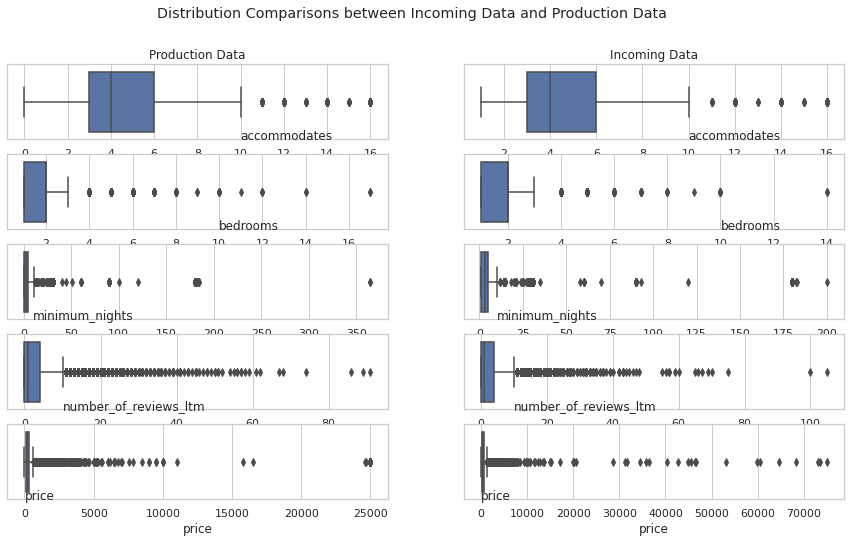

In [0]:
print(f"Let's look at the box plots of the features that exceed the stats_threshold_limit of {stats_threshold_limit}")
plot_boxplots(unique_feature_diff_array_month_2, current_prod_pdf_2, month_2_pdf)

In [0]:
print("\nLevene test.....")
check_diff_in_variances(current_prod_pdf_2, month_2_pdf, num_cols, p_threshold)



Levene test.....
No features have significantly different variances compared to production data at p-value 0.05


In [0]:
print("\nKS Test....")
check_dist_ks_bonferroni_test(current_prod_pdf_2, month_2_pdf, num_cols + [target_col], p_threshold)


KS Test....
The Bonferroni-corrected alpha level is 0.0063. Any features with KS statistic below this alpha level have shifted significantly.
The feature(s) below have significantly different distributions compared to production data at Bonferroni-corrected alpha level of 0.0063, according to the KS test
	 {'price': 0.0}


In [0]:
check_categorical_diffs(current_prod_pdf_2, month_2_pdf, cat_cols, p_threshold)

In [0]:
# Append the new month of data (where listings are most expensive across the board)
month_2_df.withColumn("month", F.lit("month_2")).write.format("delta").partitionBy("month").mode("append").save(gold_delta_path)

In [0]:
# Set the month number - used for naming the MLflow run and logged as a parameter
month = 2
 
# Specify name of MLflow run
run_name = f"month_{month}"
 
# Define the parameters to pass in the RandomForestRegressor model
model_params = {"n_estimators": 500,
                "max_depth": 5,
                "max_features": "log2"}
 
# Define a dictionary of parameters that we would like to use during preprocessing
misc_params = {"month": month,
               "target_col": target_col,
               "cat_cols": cat_cols,
               "num_cols": num_cols}
 
# Trigger model training and logging to MLflow
month_2_run = train_sklearn_rf_model(run_name, 
                                     gold_delta_path, 
                                     model_params, 
                                     misc_params)

<command-4119769509187986>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  median_vals = pdf.median()


In [0]:
# Register model to MLflow Model Registry
month_2_run_id = month_2_run.info.run_id
month_2_model_version = mlflow.register_model(model_uri=f"runs:/{month_2_run_id}/model", name=registry_model_name)


Registered model 'airbnb_hawaii' already exists. Creating a new version of this model...
2023/02/05 10:22:28 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: airbnb_hawaii, version 5
Created version '5' of model 'airbnb_hawaii'.


In [0]:

# Transition model to Staging
month_2_model_version = transition_model(month_2_model_version, stage="Staging")
print(month_2_model_version)

<ModelVersion: creation_timestamp=1675592548275, current_stage='Staging', description='', last_updated_timestamp=1675592572732, name='airbnb_hawaii', run_id='57ce4ffaf53a474eb679fa88b141833e', run_link='', source='dbfs:/databricks/mlflow-tracking/4119769509188008/57ce4ffaf53a474eb679fa88b141833e/artifacts/model', status='READY', status_message='', tags={}, user_id='5792412687435845', version='5'>


In [0]:
current_staging_run_2 = get_run_from_registered_model(registry_model_name, stage="Staging")
metric_to_check = "test_r2"
compare_model_perfs(current_staging_run_2, current_prod_run_2, min_model_r2_threshold, metric_to_check)

Staging run's test_r2: 0.064
Current production run's test_r2: 0.103
ALERT: The current staging run underperforms by -37.37% when compared to the production model. Do not transition the staging model to production.
